In [1]:
import os, sys, mne, socket, time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nilearn import plotting
from itertools import product

# Decoding tools
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mne.decoding import (
    CSP,
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    GeneralizingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)

from initialization import load_paths
from preprocFuncs import getRawData, getTrials
# from plotters import plotPower, plotRSA, plotDiffRSA
from decodeHelpers import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
subjList = [1, 3, 5, 6, 7, 12, 14, 17, 23]
# subjList = [1, 3, 5, 6, 7, 10, 12, 14, 15, 17, 22, 23, 25, 26, 27]


scores_notms_meta = None
t_down_notms_meta = None
scores_tms_meta = None
t_down_tms_meta = None

for subjID in subjList:
    print(f"Running subject {subjID}")
    master_df =  pd.read_csv('/d/DATD/datd/MD_TMS_EEG/analysis/meta_analysis/master_df_calib.csv')
    notmsday = master_df[(master_df['subjID'] == subjID) & (master_df['istms']==0)]['day'].unique()[0]
    days_valid = [1, 2, 3]
    tmsdays = [day for day in days_valid if day != notmsday]
    tmsday = tmsdays[-1]

    freq_band = 'alpha'
    POWPHASE = ['pow', 'phase']
    TYPECOND = ['byPF_pro', 'byPF_anti', 'byPF_stimin', 'byPF_respin', 'byTrlType']
    pow_or_phase = 'pow'
    typeCond = 'byPF_pro'

    p = load_paths(subjID, notmsday)
    data = np.load(f"{p['EEGroot']}_{pow_or_phase}_{typeCond}.npy.npz")
    scores_mean = data['scores_mean']
    t_down = data['t_array_down']

    if scores_notms_meta is None:
        scores_notms_meta = scores_mean[:, :, np.newaxis]
        t_down_notms_meta = t_down[:, np.newaxis]
    else:
        scores_notms_meta = np.concatenate((scores_notms_meta, scores_mean[:,:,np.newaxis]), axis=2)
        t_down_notms_meta = np.concatenate((t_down_notms_meta, t_down[:, np.newaxis]), axis=1)

    p = load_paths(subjID, tmsday)
    data = np.load(f"{p['EEGroot']}_{pow_or_phase}_{typeCond}.npy.npz")
    scores_mean = data['scores_mean']
    t_down = data['t_array_down']

    if scores_tms_meta is None:
        scores_tms_meta = scores_mean[:, :, np.newaxis]
        t_down_tms_meta = t_down[:, np.newaxis]
    else:
        scores_tms_meta = np.concatenate((scores_tms_meta, scores_mean[:,:,np.newaxis]), axis=2)
        t_down_tms_meta = np.concatenate((t_down_tms_meta, t_down[:, np.newaxis]), axis=1)    

t_array_notms_down = np.mean(t_down_notms_meta, axis=1)
t_array_tms_down = np.mean(t_down_tms_meta, axis=1)

Running subject 1
Running subject 3
Running subject 5
Running subject 6
Running subject 7
Running subject 12
Running subject 14
Running subject 17
Running subject 23


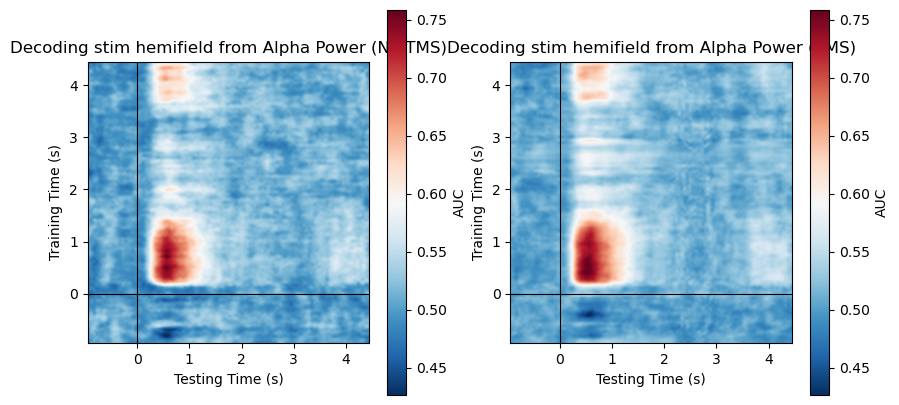

In [8]:
f, axs = plt.subplots(1, 2, figsize=(10, 5))
im = axs[0].imshow(scores_notms_meta.mean(axis=2), 
               interpolation='lanczos', 
               origin='lower', 
               cmap='RdBu_r', 
               extent=[t_array_notms_down[0], t_array_notms_down[-1], t_array_notms_down[0], t_array_notms_down[-1]],
               )
axs[1].imshow(scores_tms_meta.mean(axis=2),
                interpolation='lanczos', 
                origin='lower', 
                cmap='RdBu_r', 
                extent=[t_array_tms_down[0], t_array_tms_down[-1], t_array_tms_down[0], t_array_tms_down[-1]],
                )
axs[0].set_title('Decoding stim hemifield from Alpha Power (No TMS)')
axs[1].set_title('Decoding stim hemifield from Alpha Power (TMS)')
for ax in axs:
    ax.axhline(0, color='k', lw=0.8)
    ax.axvline(0, color='k', lw=0.8)
    ax.set_xlabel('Testing Time (s)')
    ax.set_ylabel('Training Time (s)')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('AUC')
plt.show()

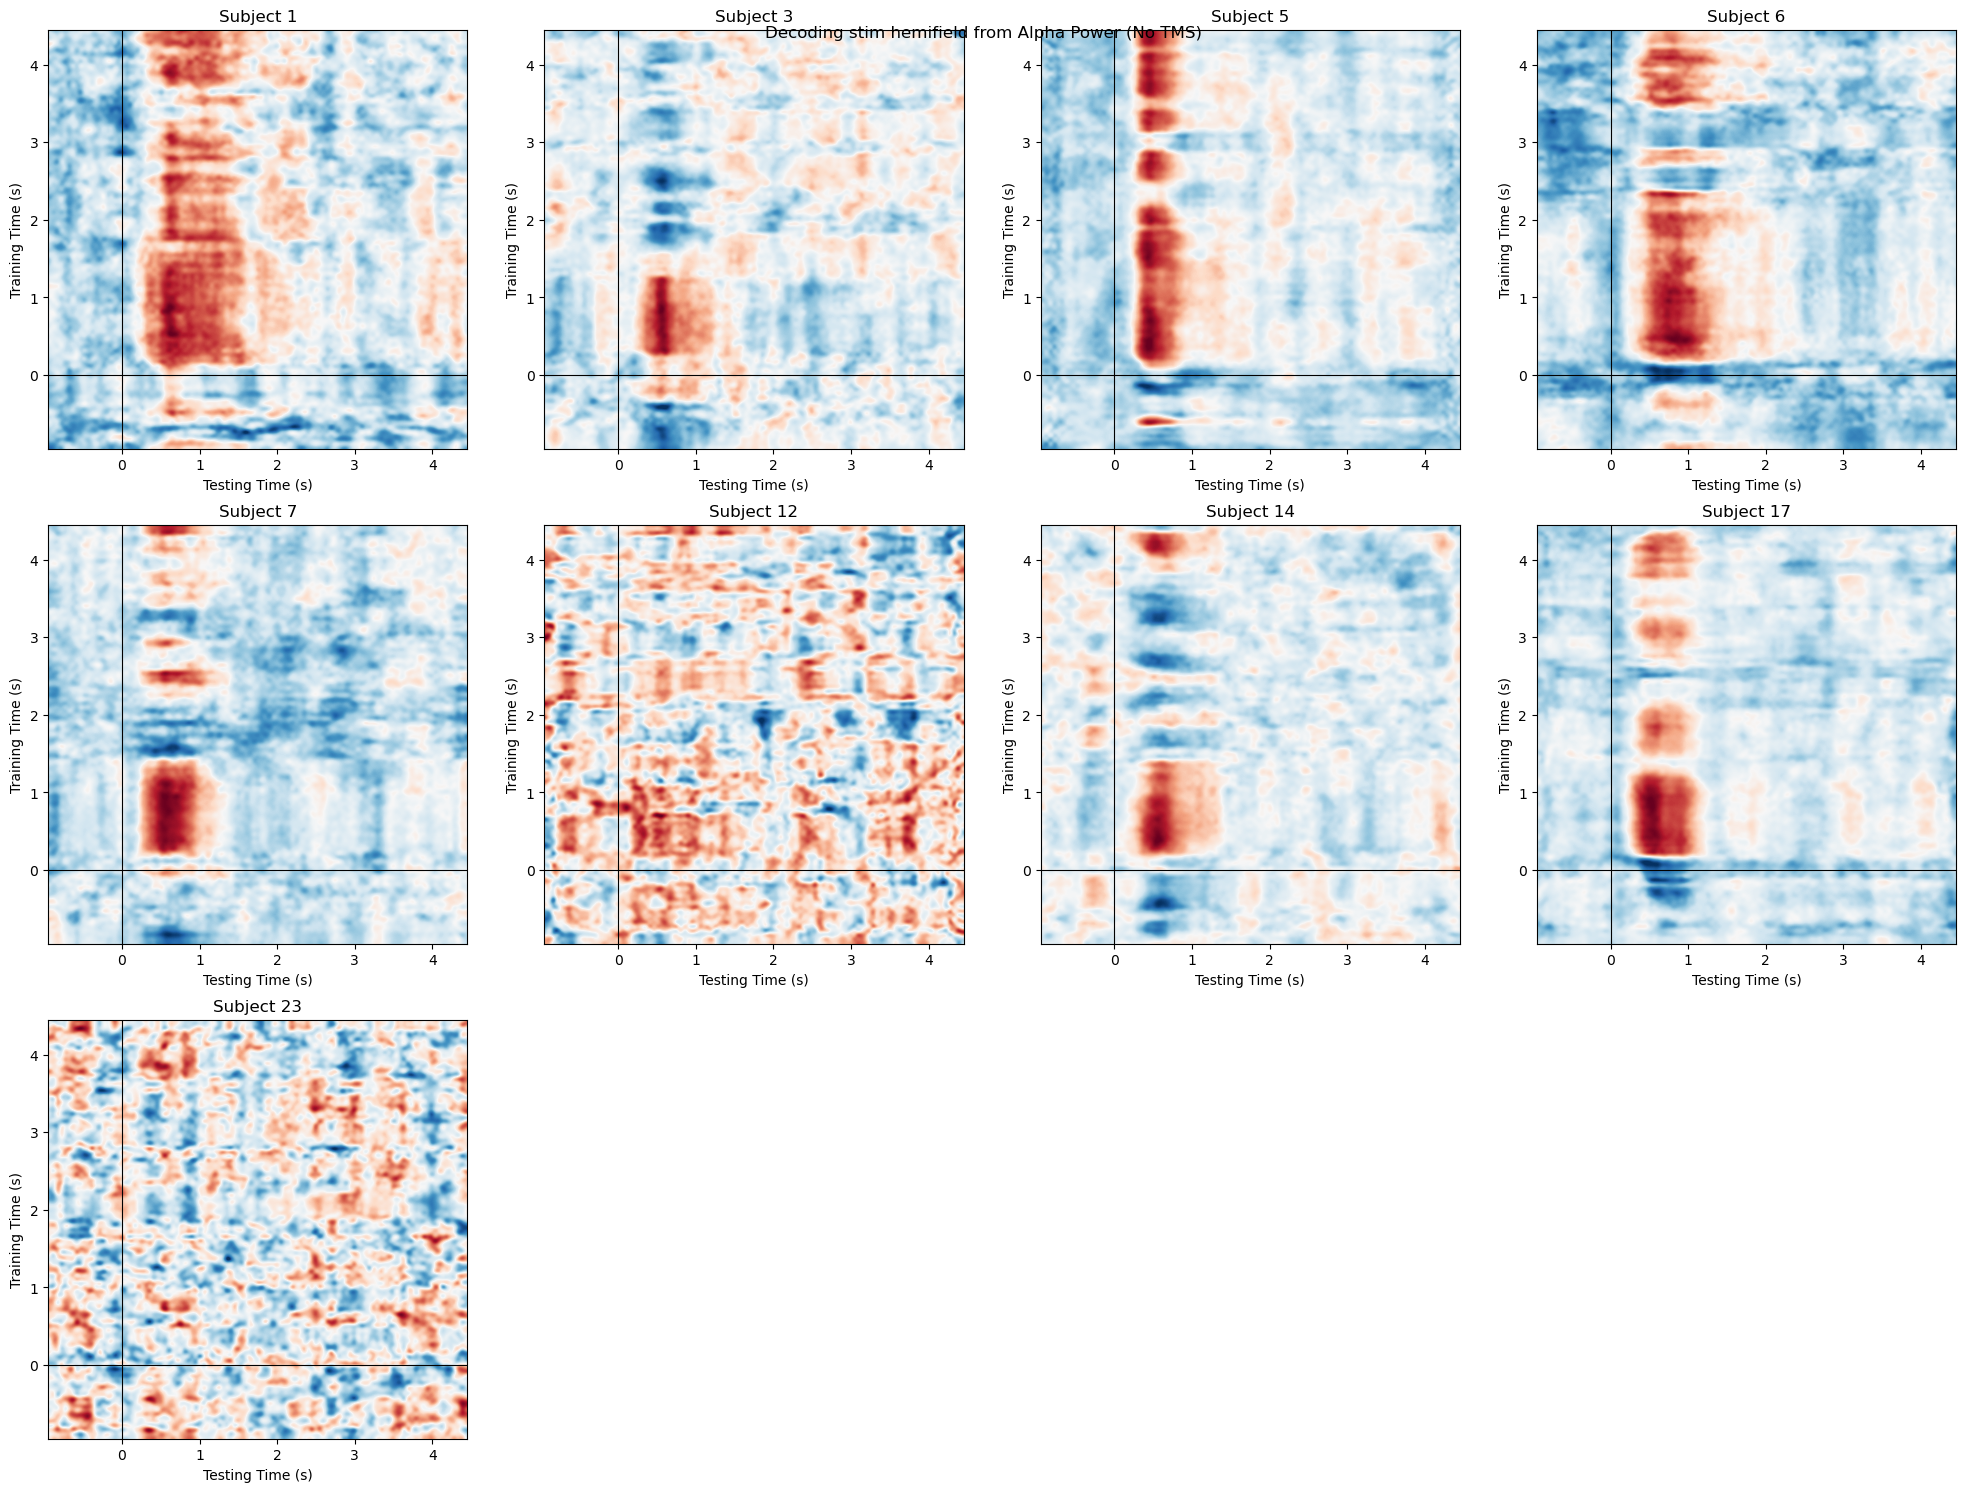

In [9]:
nsubs = scores_notms_meta.shape[2]
ncols = 4
nrows = int(np.ceil(nsubs / ncols))
f, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 5))
axs = axs.flatten()
for i, ax in enumerate(axs):
    if i < nsubs:
        ax.imshow(scores_notms_meta[:, :, i], 
                  interpolation='lanczos', 
                  origin='lower', 
                  cmap='RdBu_r', 
                  extent=[t_array_notms_down[0], t_array_notms_down[-1], t_array_notms_down[0], t_array_notms_down[-1]],
                  )
        ax.axhline(0, color='k', lw=0.8)
        ax.axvline(0, color='k', lw=0.8)
        ax.set_xlabel('Testing Time (s)')
        ax.set_ylabel('Training Time (s)')
        ax.set_title(f'Subject {subjList[i]}')
    else:
        ax.axis('off')
plt.tight_layout()
plt.suptitle('Decoding stim hemifield from Alpha Power (No TMS)')
plt.show()

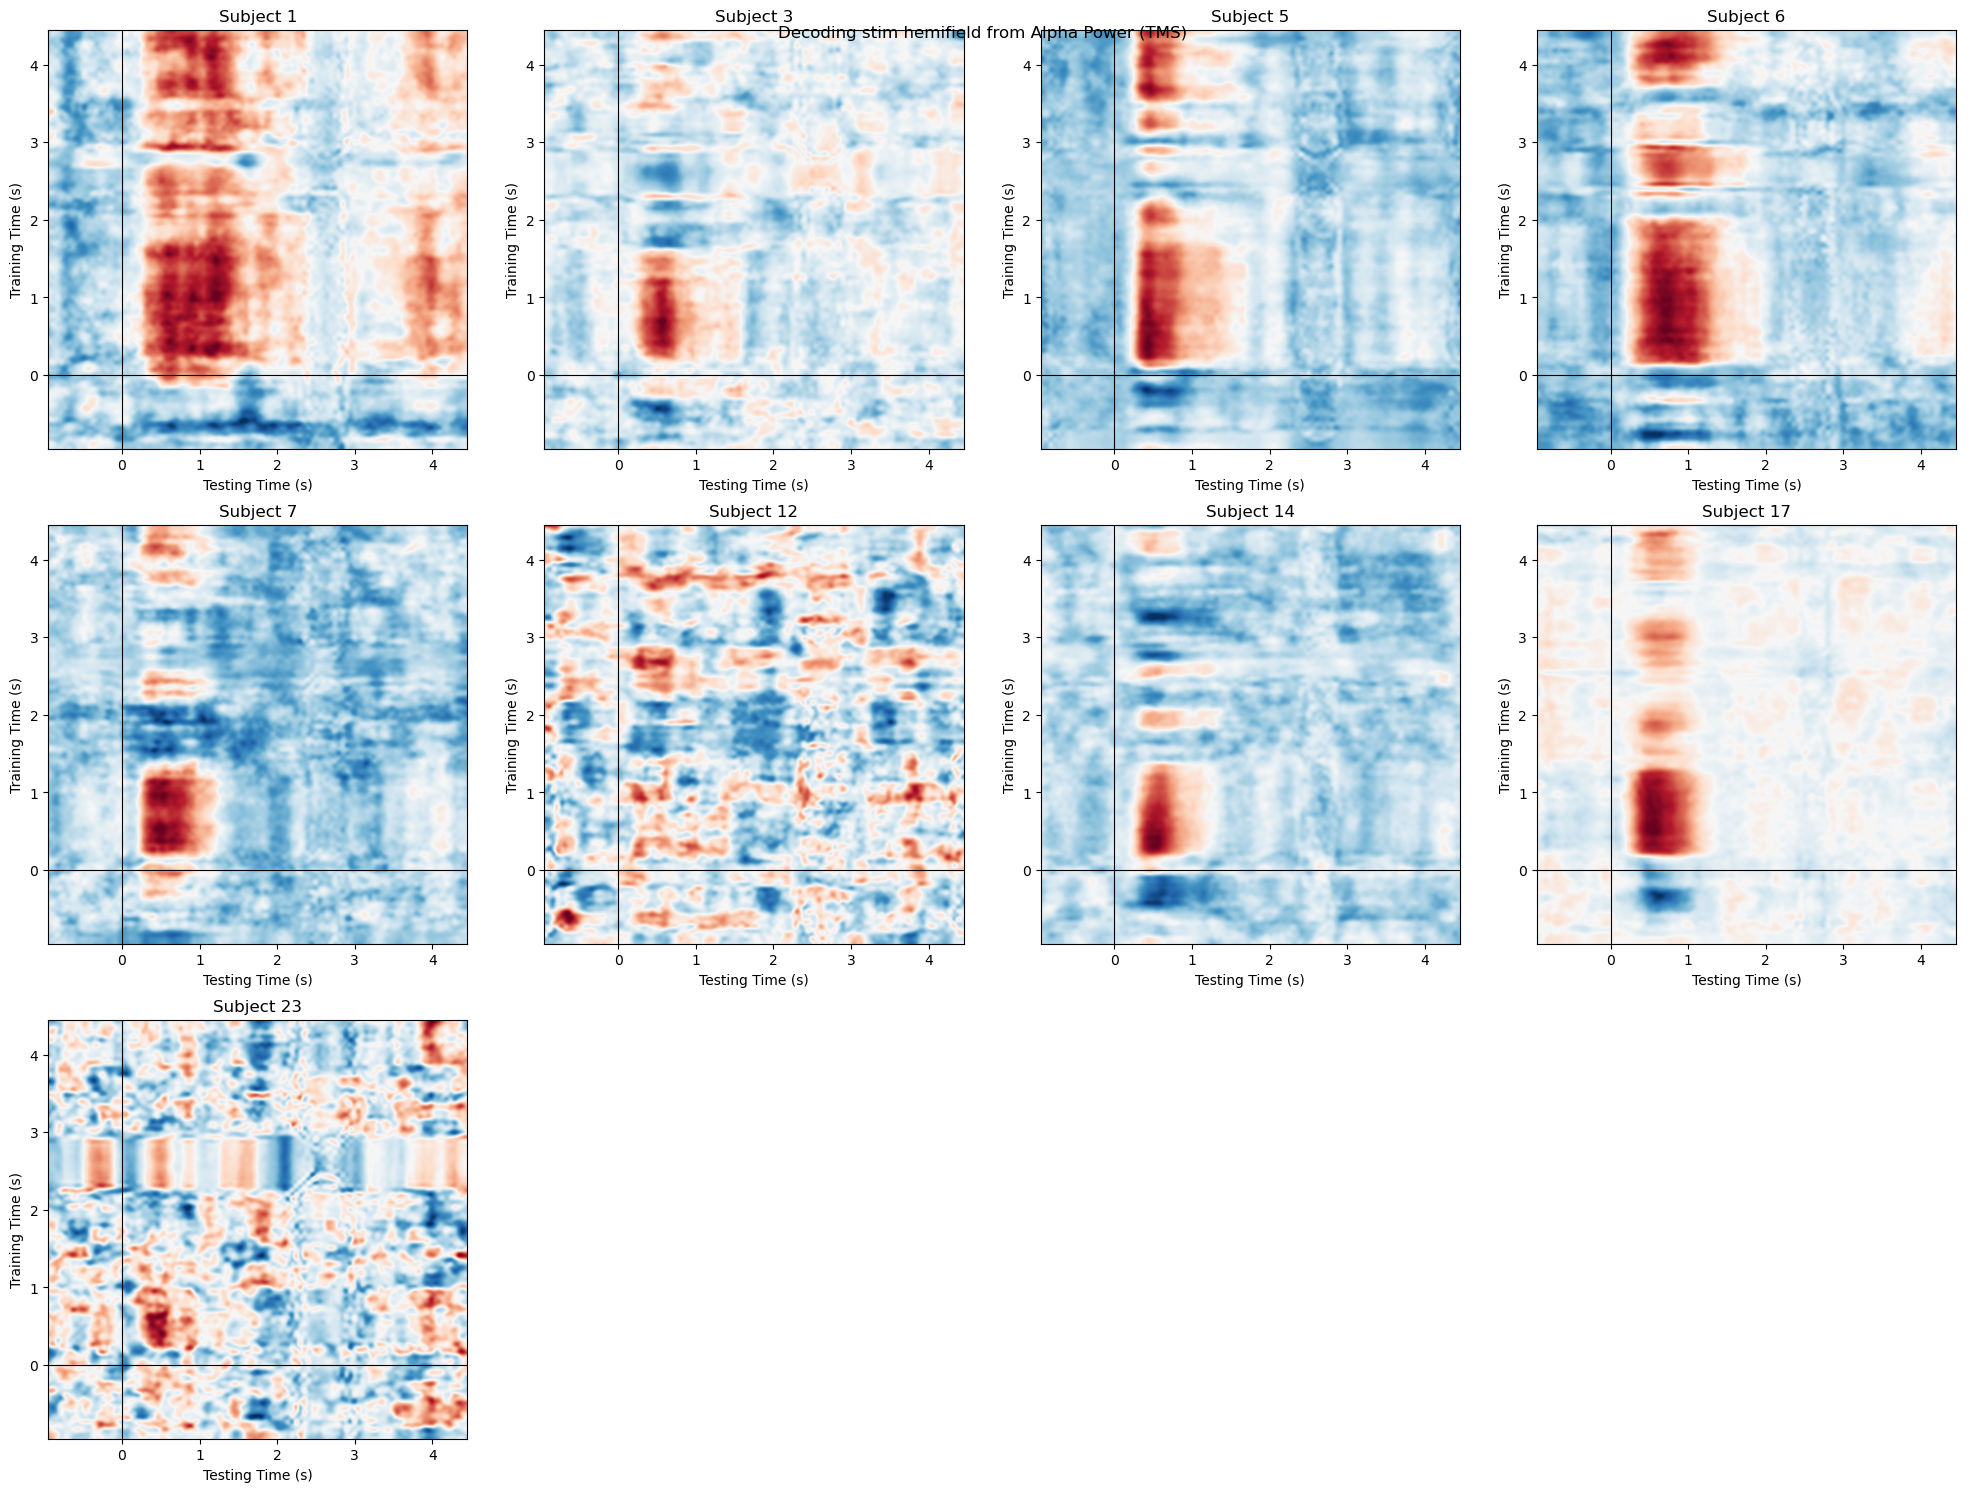

In [10]:
nsubs = scores_tms_meta.shape[2]
ncols = 4
nrows = int(np.ceil(nsubs / ncols))
f, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 5))
axs = axs.flatten()
for i, ax in enumerate(axs):
    if i < nsubs:
        ax.imshow(scores_tms_meta[:, :, i], 
                  interpolation='lanczos', 
                  origin='lower', 
                  cmap='RdBu_r', 
                  extent=[t_array_tms_down[0], t_array_tms_down[-1], t_array_tms_down[0], t_array_tms_down[-1]],
                  )
        ax.axhline(0, color='k', lw=0.8)
        ax.axvline(0, color='k', lw=0.8)
        ax.set_xlabel('Testing Time (s)')
        ax.set_ylabel('Training Time (s)')
        ax.set_title(f'Subject {subjList[i]}')
    else:
        ax.axis('off')
plt.tight_layout()
plt.suptitle('Decoding stim hemifield from Alpha Power (TMS)')
plt.show()